In [96]:
import numpy as np
import pandas as pd

from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, SelectKBest, chi2, f_regression, RFE, SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor

In [11]:
file='cleaned_data.csv'
data=pd.read_csv(file)
data.head()

,Date,Zone1Position,Zone2Position,Zone3Position,SKU,Zone1_Row_Num,Zone1_Col_Num,Zone2_Row_Num,Zone2_Col_Num,Zone3_Row_Num,...,Zone2_Humidity_Max,Zone2_Humidity_Range,Zone3_Humidity_Avg,Zone3_Humidity_Min,Zone3_Humidity_Max,Zone3_Humidity_Range,Block_Num,Block_Position,Block_Orientation,Result_Type
0,09/01/2020,3.0,2.0,3.0,A001,1.0,3.0,1.0,2.0,1.0,...,61.80,10.0,39.19,33.19,45.19,12.0,1000.0,1.0,1,Defect_1
1,03/12/2019,8.0,4.0,3.0,A001,2.0,4.0,2.0,2.0,1.0,...,58.12,16.0,48.50,40.50,56.50,16.0,1003.0,1.0,1,Defect_1
2,21/11/2019,4.0,2.0,3.0,B003,1.0,4.0,1.0,2.0,1.0,...,50.97,10.0,52.20,46.20,58.20,12.0,1001.0,4.0,1,PASS
3,22/11/2019,6.0,3.0,1.0,B003,2.0,2.0,2.0,1.0,1.0,...,59.13,4.0,39.29,31.29,47.29,16.0,1003.0,2.0,1,PASS
4,23/12/2019,3.0,2.0,3.0,B003,1.0,3.0,1.0,2.0,1.0,...,65.80,18.0,45.37,42.37,48.37,6.0,1002.0,1.0,1,PASS


In [18]:
data[['Zone1Position','Zone2Position','Zone3Position','Zone1_Row_Num','Zone1_Col_Num',
      'Zone2_Row_Num', 'Zone2_Col_Num','Zone3_Row_Num', 'Zone3_Col_Num','Zone1_Left_Block_Bin',
      'Zone1_Right_Block_Bin','Block_Num',
      'Block_Position']] =data[['Zone1Position','Zone2Position','Zone3Position','Zone1_Row_Num',
                                'Zone1_Col_Num','Zone2_Row_Num', 'Zone2_Col_Num','Zone3_Row_Num', 
                                'Zone3_Col_Num','Zone1_Left_Block_Bin','Zone1_Right_Block_Bin',
                                'Block_Num','Block_Position']].astype(int)


In [34]:
#Defining input features and target

X = data.drop(['Result_Type'], axis=1)
y = data['Result_Type']

#splitting data into trained and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#splitting trained into trained and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) 

#exploring shape of data
print(f"Shape of the training set: {X_train.shape}, {y_train.shape}")
print(f"Shape of the validation set: {X_val.shape}, {y_val.shape}")
print(f"Shape of the test set: {X_test.shape}, {y_test.shape}")

Shape of the training set: (44904, 51), (44904,)
Shape of the validation set: (14968, 51), (14968,)
Shape of the test set: (14968, 51), (14968,)


In [43]:
cat_features=['SKU','Zone1_Area', 'Zone3_Area']
date_feature='Date'
num_features=[col for col in X.columns.to_list() if col not in cat_features+[date_feature]]

### 1. Feature engineering

In [130]:
# Rescaling numerical and encoding categorical and date features
min_max_scaler = MinMaxScaler()

X_train_scaled = min_max_scaler.fit_transform(X_train[num_features])
X_val_scaled = min_max_scaler.transform(X_val[num_features])
X_test_scaled = min_max_scaler.transform(X_test[num_features])

one_hot_encoder=OneHotEncoder()
X_train_cat=one_hot_encoder.fit_transform(X_train[cat_features])
X_val_cat = one_hot_encoder.transform(X_val[cat_features])
X_test_cat = one_hot_encoder.transform(X_test[cat_features])

ordinal_encoder=OrdinalEncoder()
X_train_date = ordinal_encoder.fit_transform(X_train[[date_feature]])
X_val_date = ordinal_encoder.transform(X_val[[date_feature]])
X_test_date = ordinal_encoder.transform(X_test[[date_feature]])

cat_feature_names = one_hot_encoder.get_feature_names_out(cat_features)

X_train_final=np.concatenate((X_train_scaled,X_train_cat.toarray(),X_train_date), axis=1)
X_val_final = np.concatenate((X_val_scaled, X_val_cat.toarray(), X_val_date), axis=1)
X_test_final = np.concatenate((X_test_scaled, X_test_cat.toarray(), X_test_date), axis=1)


encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.fit_transform(y_val)
y_test_encoded = encoder.fit_transform(y_test)


In [131]:
all_features=np.concatenate((num_features, cat_feature_names,[date_feature]))

#### a. Filter-based methods

In [109]:
# Using VarianceThreshold class to identify features with low variance
var_thres = VarianceThreshold(threshold=0.1)
X_train_var = var_thres.fit_transform(X_train_final)
X_val_var = var_thres.transform(X_val_final)
X_test_var = var_thres.transform(X_test_final)

selected_features = all_features[var_thres.get_support()]

print(f"Number of selected features: {len(selected_features)}")
print(f"Names of selected features: {selected_features}")

Number of selected features: 24
Names of selected features: ['Zone1Position' 'Zone2Position' 'Zone3Position' 'Zone1_Row_Num'
 'Zone1_Col_Num' 'Zone2_Row_Num' 'Zone2_Col_Num' 'Zone3_Row_Num'
 'Zone3_Col_Num' 'Zone1_Left_Block_Bin' 'Zone1_Right_Block_Bin'
 'Zone2_Temp_Range' 'Block_Num' 'Block_Position' 'SKU_A001' 'SKU_C005'
 'SKU_Z009' 'Zone1_Area_Bottom Left' 'Zone1_Area_Bottom Right'
 'Zone1_Area_Top Left' 'Zone1_Area_Top Right' 'Zone3_Area_Bottom Right'
 'Zone3_Area_Top Left' 'Date']


**Mutual information score**
- how much information one variable contains regarding another = A higher mutual information score means that the variables are more related and informative, and a lower mutual information score means that the variables are less related and informative.
- based on the concept of entropy  or how uncertain/unpredictable a variable is.<br>
    I(X;Y)=H(X)+H(Y)−H(X,Y)<br>
    where I(X;Y) is the mutual information between variables X and Y, H(X) is the entropy of variable X, H(Y) is the entropy of variable Y, and H(X,Y) is the joint entropy of variables X and Y<br>
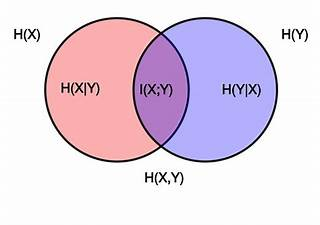

In [110]:
mutual_info = mutual_info_classif(X_train_final, y_train_encoded)
sorted_features = sorted(zip(mutual_info, selected_features), reverse=True)

keep_mis=[]
print(f"Mutual information scores and names of the sorted features:")
for score, name in sorted_features:
    print(f"{score:.3f} - {name}")
    if score>=0.05: # keep everything over 0.05
        keep_mis.append(name)

Mutual information scores and names of the sorted features:
0.151 - Zone1Position
0.146 - Zone2Position
0.088 - Zone2_Col_Num
0.087 - Zone1_Right_Block_Bin
0.086 - Zone1_Col_Num
0.084 - Zone1_Left_Block_Bin
0.078 - Zone3Position
0.067 - Zone3_Col_Num
0.061 - Zone1_Area_Bottom Left
0.057 - Zone1_Row_Num
0.056 - Zone2_Row_Num
0.010 - Zone3_Row_Num
0.002 - SKU_C005
0.001 - Date
0.001 - Zone2_Temp_Range
0.001 - Zone3_Area_Top Left
0.000 - Zone3_Area_Bottom Right
0.000 - Zone1_Area_Top Right
0.000 - Zone1_Area_Top Left
0.000 - Zone1_Area_Bottom Right
0.000 - SKU_Z009
0.000 - SKU_A001
0.000 - Block_Position
0.000 - Block_Num


**Chi-squared test**

In [111]:
skb_chi2 = SelectKBest(chi2, k=16)
X_skb_chi2 = skb_chi2.fit_transform(X_train_final, y_train_encoded)
chi_keep=all_features[skb_chi2.get_support()]
print('Features selected by chi-squared test:', chi_keep)

Features selected by chi-squared test: ['Zone1Position' 'Zone2Position' 'Zone1_Row_Num' 'Zone1_Col_Num'
 'Zone2_Row_Num' 'Zone2_Col_Num' 'Zone3_Col_Num' 'Zone1_Left_Block_Bin'
 'Zone1_Right_Block_Bin' 'SKU_A001' 'SKU_C005' 'Zone1_Area_Bottom Right'
 'Zone1_Area_Top Left' 'Zone1_Area_Top Right' 'Zone3_Area_Bottom Right'
 'Zone3_Area_Top Left']


**ANOVA F-test**

In [112]:
skb_f = SelectKBest(f_regression, k=16)
X_skb_f = skb_f.fit_transform(X_train_final, y_train_encoded)
anova_keep=all_features[skb_f.get_support()]
print('Features selected by ANOVA F-test:', anova_keep)

Features selected by ANOVA F-test: ['Zone1Position' 'Zone2Position' 'Zone1_Row_Num' 'Zone1_Col_Num'
 'Zone2_Row_Num' 'Zone2_Col_Num' 'Zone3_Col_Num' 'Zone1_Left_Block_Bin'
 'Zone1_Right_Block_Bin' 'Zone1_In_Zone3_Out_Dur' 'Zone3_Temp_Min'
 'Zone3_Temp_Range' 'SKU_A001' 'Zone1_Area_Top Left'
 'Zone3_Area_Bottom Right' 'Zone3_Area_Top Left']


Summary: Exploring the features selected based on mutual information score, Chi-square test and ANOVA F-test

In [113]:
def get_common(list1, list2, list3):
    set1 = set(list1)
    set2 = set(list2)
    set3 = set(list3)

    common_all = set1.intersection(set2, set3)
    print('Values common to all three lists:', common_all)
    print(len(common_all))
    common_two = (set1.intersection(set2) - set3) | (set1.intersection(set3) - set2) | (set2.intersection(set3) - set1)
    print('Values common to only two lists:', common_two)

    unique_each = (set1 - set2 - set3) | (set2 - set1 - set3) | (set3 - set1 - set2)
    print('Values unique to each list:', unique_each)
    return common_all

In [114]:
filter_common=get_common(keep_mis, chi_keep, anova_keep)

Values common to all three lists: {'Zone1Position', 'Zone2_Col_Num', 'Zone1_Left_Block_Bin', 'Zone2_Row_Num', 'Zone2Position', 'Zone1_Row_Num', 'Zone1_Right_Block_Bin', 'Zone3_Col_Num', 'Zone1_Col_Num'}
9
Values common to only two lists: {'Zone3_Area_Top Left', 'Zone3_Area_Bottom Right', 'Zone1_Area_Top Left', 'SKU_A001'}
Values unique to each list: {'Zone3_Temp_Min', 'Zone1_Area_Top Right', 'Zone1_In_Zone3_Out_Dur', 'Zone3Position', 'Zone1_Area_Bottom Left', 'Zone3_Temp_Range', 'SKU_C005', 'Zone1_Area_Bottom Right'}


**b. Wrapper-based method** - using search algorithm to find the optimal subset of features that maximizes the performance of the machine learning model.
- **Forward selection**: starting with an empty set of features and adding one feature at a time that improves the performance of the model the most. It stops when no further improvement is possible or a predefined number of features is reached
- **Backward elimination**: is similar to the Foward selection method but reversed. It starts with all the features and removes one feature at a time that degrades the performance of the model the least. It stops when no further improvement is possible or a predefined number of features is reached.
- **Recursive feature elimination**: recursively fits the model and removes the least important features until a predefined number of features is reached. It uses the feature importances or coefficients of the model to rank the features.

**Forward selection method** using SequentialFeatureSelector

In [115]:
estimator = LinearRegression()
selector = SequentialFeatureSelector(estimator, n_features_to_select=16, direction='forward')

selector.fit(X_train_final, y_train_encoded)
forward_keep=all_features[selector.get_support()]
print('Features selected by forward selection:', forward_keep)

Features selected by forward selection: ['Zone1_Col_Num' 'Zone3_Col_Num' 'Zone1_Out_Zone2_In_Dur'
 'Zone1_In_Zone3_Out_Dur' 'Zone3_Temp_Avg' 'Zone3_Temp_Range'
 'Zone1_Humidity_Min' 'Zone2_Humidity_Max' 'Zone3_Humidity_Min'
 'Zone3_Humidity_Range' 'Block_Num' 'Block_Position' 'SKU_A001' 'SKU_C005'
 'Zone1_Area_Top Left' 'Zone3_Area_Bottom Right']


**Backward elimination**
- looks at scoring function that evaluates the model as a whole: p-value, AIC, BIC, or cross-validation score
- can stop when no further improvement is possible or a predefined number of features is reached

In [116]:
selector = SequentialFeatureSelector(estimator, n_features_to_select=16, direction='backward')

selector.fit(X_train_final, y_train_encoded)
backward_keep=all_features[selector.get_support()]
print('Features selected by forward selection:', backward_keep)

Features selected by forward selection: ['Zone1Position' 'Zone3Position' 'Zone1_Row_Num' 'Zone3_Row_Num'
 'Zone3_Col_Num' 'Zone1_Left_Block_Bin' 'Zone1_Out_Zone2_In_Dur'
 'Zone1_In_Zone3_Out_Dur' 'Zone3_Temp_Range' 'Zone3_Humidity_Min'
 'Zone3_Humidity_Range' 'Block_Num' 'Block_Position' 'SKU_A001' 'SKU_C005'
 'Zone1_Area_Top Right']


**Recursive feature elimination**
- uses the feature importances or coefficients of the model to rank the features, and removes the least important feature at each iteration
- requires the user to specify the number of features to select in advance, and stops when that number is reached

In [117]:
# Select the 5 best features using linear regression as the estimator
rfe = RFE(estimator, n_features_to_select=16)
X_rfe = rfe.fit_transform(X_train_final, y_train_encoded)
lm_keep=all_features[rfe.get_support()]
print('Features selected by recursive feature elimination:', lm_keep)


Features selected by recursive feature elimination: ['Zone2Position' 'Zone3Position' 'Zone1_Row_Num' 'Zone2_Row_Num'
 'Zone2_Col_Num' 'Zone3_Row_Num' 'Zone3_Col_Num' 'Zone1_Left_Block_Bin'
 'Zone1_Right_Block_Bin' 'Zone1_Temp_Min' 'Zone1_Temp_Max'
 'Zone1_Temp_Range' 'Zone1_Humidity_Min' 'Zone1_Humidity_Max'
 'Zone1_Humidity_Range' 'Zone1_Area_Bottom Right']


In [118]:
wrapper_common=get_common(forward_keep, backward_keep, lm_keep)

Values common to all three lists: {'Zone3_Col_Num'}
1
Values common to only two lists: {'Zone1_Left_Block_Bin', 'Zone3_Temp_Range', 'Zone3Position', 'Zone3_Humidity_Range', 'Block_Num', 'Zone3_Row_Num', 'Zone1_Row_Num', 'Zone1_In_Zone3_Out_Dur', 'Zone1_Humidity_Min', 'Block_Position', 'Zone3_Humidity_Min', 'Zone1_Out_Zone2_In_Dur', 'SKU_A001', 'SKU_C005'}
Values unique to each list: {'Zone1_Temp_Max', 'Zone2_Col_Num', 'Zone3_Area_Bottom Right', 'Zone1_Temp_Min', 'Zone2_Row_Num', 'Zone2Position', 'Zone1_Right_Block_Bin', 'Zone1_Temp_Range', 'Zone1_Humidity_Max', 'Zone1_Area_Bottom Right', 'Zone1Position', 'Zone3_Temp_Avg', 'Zone1_Area_Top Left', 'Zone2_Humidity_Max', 'Zone1_Area_Top Right', 'Zone1_Humidity_Range', 'Zone1_Col_Num'}


**c. Embedded method** - using algorithms that have built-in feature selection mechanisms, such as regularization or tree-based methods. E.g. Lasso, Ridge, Elastic Net, and Random Forest

**Lasso** - selecting features with non-zero coefficients using Lasso with alpha=0.1

In [119]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_final, y_train_encoded)
lasso_keep=all_features[lasso.coef_ != 0]
print('Features selected by Lasso:', lasso_keep)

Features selected by Lasso: ['SKU_A001' 'Zone1_Area_Top Left']


**Elastic net** - uses a combination of L1 and L2 penalties to shrink the coefficients of the features. It can select features by setting some coefficients to zero, like lasso, and also reduce the collinearity among the features, like ridge

In [120]:
enet = ElasticNet(alpha=0.1, l1_ratio=0.5)
enet.fit(X_train_final, y_train_encoded)
enet_keep=all_features[enet.coef_ != 0]
print('Features selected by elastic net:', enet_keep)


Features selected by elastic net: ['Zone2Position' 'Zone1_Row_Num' 'Zone2_Row_Num' 'Zone2_Col_Num'
 'Zone1_Left_Block_Bin' 'Zone1_Right_Block_Bin' 'Zone3_Temp_Range'
 'SKU_A001' 'Zone1_Area_Top Left']


**Random Forest** - selecting features with importance above the mean importance

In [121]:
rf = RandomForestRegressor(random_state=0)
rf.fit(X_train_final, y_train_encoded)
feature_importances = pd.Series(rf.feature_importances_, index=all_features)
rf_keep=feature_importances[feature_importances > feature_importances.mean()].index
print('Features selected by Random Forest:', rf_keep)


Features selected by Random Forest: Index(['Zone1Position', 'Zone2Position', 'Zone3_Col_Num',
       'Zone1_In_Zone3_Out_Dur', 'Zone3_Temp_Range', 'Zone3_Humidity_Max',
       'Zone3_Humidity_Range', 'Block_Num', 'Block_Position', 'SKU_A001',
       'SKU_C005', 'Zone1_Area_Top Left'],
      dtype='object')


In [123]:
embedded_common=get_common(lasso_keep, enet_keep, rf_keep)

Values common to all three lists: {'SKU_A001', 'Zone1_Area_Top Left'}
2
Values common to only two lists: {'Zone3_Temp_Range', 'Zone2Position'}
Values unique to each list: {'Zone1_Left_Block_Bin', 'Zone2_Col_Num', 'Zone1Position', 'Block_Num', 'Zone3_Humidity_Range', 'Zone2_Row_Num', 'Zone3_Humidity_Max', 'Zone1_Row_Num', 'Zone1_Right_Block_Bin', 'Zone1_In_Zone3_Out_Dur', 'Block_Position', 'SKU_C005', 'Zone3_Col_Num'}


In [133]:
list(filter_common)

['Zone1Position',
 'Zone2_Col_Num',
 'Zone1_Left_Block_Bin',
 'Zone2_Row_Num',
 'Zone2Position',
 'Zone1_Row_Num',
 'Zone1_Right_Block_Bin',
 'Zone3_Col_Num',
 'Zone1_Col_Num']

In [134]:
X_train_model = min_max_scaler.fit_transform(X_train[list(filter_common)])
X_val_model = min_max_scaler.transform(X_val[list(filter_common)])
X_test_model = min_max_scaler.transform(X_test[list(filter_common)])

### 2. Modelling

In [151]:
log_reg = LogisticRegression(multi_class='multinomial', max_iter=10000)
log_reg.fit(X_train_model, y_train)

y_prob = log_reg.predict_proba(X_val_model)
y_pred = log_reg.predict(X_val_model)

In [152]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='micro')
recall = recall_score(y_val, y_pred, average='micro')
f1 = f1_score(y_val, y_pred, average='micro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


Accuracy: 0.719802244788883
Precision: 0.719802244788883
Recall: 0.719802244788883
F1-score: 0.7198022447888829


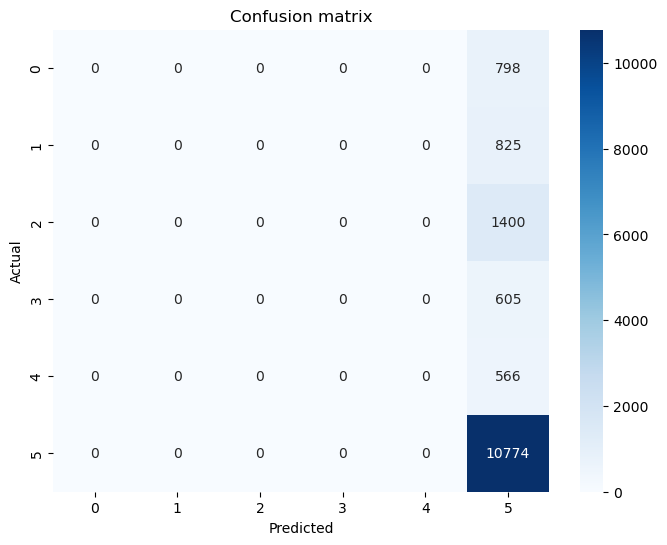

In [153]:
# Plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [161]:
y.value_counts()

Result_Type
PASS        54057
Defect_3     6735
Defect_1     3991
Defect_2     3971
Defect_4     3115
Defect_5     2971
Name: count, dtype: int64

In [ ]:
# Import libraries
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

# Load the iris dataset
X, y = load_iris(return_X_y=True)
X = pd.DataFrame(X, columns=load_iris().feature_names)
y = pd.Series(y, name='species')

# Make the data imbalanced by removing some examples of class 0 and 1
X = X[y != 2].iloc[:80]
y = y[y != 2].iloc[:80]

# Define the multinomial logistic regression model
log_reg = LogisticRegression(multi_class='multinomial', max_iter=10000)

# Fit the model to the imbalanced data
log_reg.fit(X, y)

# Make predictions with the model
y_pred = log_reg.predict(X)

# Print the confusion matrix of the model
print('Confusion matrix of the model on imbalanced data:')
print(confusion_matrix(y, y_pred))

# Define the SMOTE resampler
smote = SMOTE()

# Resample the data using SMOTE
X_res, y_res = smote.fit_resample(X, y)

# Fit the model to the resampled data
log_reg.fit(X_res, y_res)

# Make predictions with the model
y_pred_res = log_reg.predict(X_res)

# Print the confusion matrix of the model
print('Confusion matrix of the model on resampled data:')
print(confusion_matrix(y_res, y_pred_res))


In [162]:
#cross validation
# Import libraries
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix

# Load the iris dataset
X, y = load_iris(return_X_y=True)
X = pd.DataFrame(X, columns=load_iris().feature_names)
y = pd.Series(y, name='species')

# Define the multinomial logistic regression model with alpha=0.1 and l1_ratio=0.5
log_reg = LogisticRegression(multi_class='multinomial', max_iter=10000, alpha=0.1, l1_ratio=0.5)

# Fit the model to the data
log_reg.fit(X, y)

# Make predictions with the model
y_pred = log_reg.predict(X)

# Print the confusion matrix of the model
print('Confusion matrix of the model on original data:')
print(confusion_matrix(y, y_pred))

# Define the multinomial logistic regression model with cross-validation
log_reg_cv = LogisticRegressionCV(multi_class='multinomial', max_iter=10000)

# Fit the model to the data
log_reg_cv.fit(X, y)

# Make predictions with the model
y_pred_cv = log_reg_cv.predict(X)

# Print the confusion matrix of the model
print('Confusion matrix of the model on cross-validated data:')
print(confusion_matrix(y, y_pred_cv))

# Print the optimal values of alpha and l1_ratio
print('Optimal value of alpha:', log_reg_cv.alpha_)
print('Optimal value of l1_ratio:', log_reg_cv.l1_ratio_)


In [150]:
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_val_encoded, y_prob[:, 1]) #false positive rate and the true positive rate

roc_auc = auc(fpr, tpr) #area under the curve

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

ValueError: multiclass format is not supported

In [ ]:
Decision tree

In [ ]:
Neural networks